In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.stats
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import astropy.io.fits as fits
from astropy.modeling import models, fitting
from scipy.signal import medfilt
import scipy
from lmfit.models import GaussianModel, SkewedGaussianModel

import os

from binotools import calbino
import binotools as bt
import h5py
from sedpy.observate import load_filters, getSED

plt.style.use('seaborn-talk')
plt.rc('figure', dpi=150, figsize=(5,5))

# Binospec Telluric Correction and Flux Calibration

Flux calibration code from Ben Johnson, telluric correction by `molecfit`

Run `molecfit` in `os.environ['WORK_DIR']+'/Observing/Binospec/telluric_corrections'`

Save calib files in `os.environ['BINO_DIR']+'2649_BLAS_1/calib/'`

In [4]:
calib_dir = os.environ['BINO_DIR']+'2649_BLAS_1/calib/'

# Work on sky-subtracted data?
sky_sub = False
if sky_sub:
    skysub_lab = '_skysub'
    flux_scale = 1.
else:
    skysub_lab = ''
    flux_scale = 1.e-19

# Find stars on the mask

In [5]:
# Find the stars
slits = pd.read_csv(os.environ['BINO_DIR']+'2649_BLAS_1/masks/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

stars = slits[slits.type == 'STANDARD']
stars

,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum
19,255,1916,f_3,188.910191,62.352588,0,0,0.001,1,2000,STANDARD,6855.558347,9378.533932,A,20
20,254,1915,f_2,188.902346,62.363999,0,0,0.001,1,2000,STANDARD,6773.112436,9296.124509,A,21


# Load data

Load binospec spectra

In [6]:
datadir = os.environ['BINO_DIR']+'2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs/'

# 1D slit spectra
fname_extr = datadir+"obj_abs_slits_extr.fits"
if sky_sub:
    fname_extr = datadir+"obj-sky_slits_extr.fits"
extract1D  = fits.open(fname_extr)
print('Using %s for 1D spectra' % fname_extr)

# 2D spectra
fname_lin = datadir+"obj_abs_slits_lin.fits"
if sky_sub:
    fname_lin = datadir+"obj-sky_slits_lin.fits"
extract2D  = fits.open(fname_lin)
print('Using %s for 2D spectra' % fname_lin)

spec1D = extract1D['FLUX'].data
err1D  = extract1D['ERROR'].data

# Get wavelength vector
header  = extract1D['FLUX'].header
nstep   = spec1D.shape[1]
wave_nm = header['CRVAL1'] + np.linspace(0., nstep*header['CDELT1'], nstep)

Using /h/hobnob0/Binospec/2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs/obj_abs_slits_extr.fits for 1D spectra
Using /h/hobnob0/Binospec/2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs/obj_abs_slits_lin.fits for 2D spectra


## Save 1D spectra for telluric calcs

In [7]:
telluric_dir = calib_dir+'telluric_corrections/'
for i in [0,1]:    
    star_id = stars.index[i]
    spec1D_file = telluric_dir+'star%i_spec1D_uncalib%s.txt' % (star_id, skysub_lab)
    np.savetxt(spec1D_file, np.vstack((wave_nm, spec1D[star_id], err1D[star_id])).T)

# Telluric correction

Transmission spectrum $T(\lambda)$ obtained for each star using `molecfit`.

To do telluric correction ([Vacca+03](https://ui.adsabs.harvard.edu/abs/2003PASP..115..389V/abstract), [Sameshima+18](https://ui.adsabs.harvard.edu/abs/2018PASP..130g4502S/abstract)), assuming std star and target at same airmass:

$$ S_{corr}(\lambda) = \frac{S_{obs}}{T(\lambda - \alpha)^\beta} $$

Find $\alpha$ (accounts for wavelength shifts) and $\beta$ for each spectrum such that RMS($S_{corr}$) is minimized in telluric regions. $\alpha\sim0$, $\beta\sim1$

Text(0, 0.5, 'Transmission')

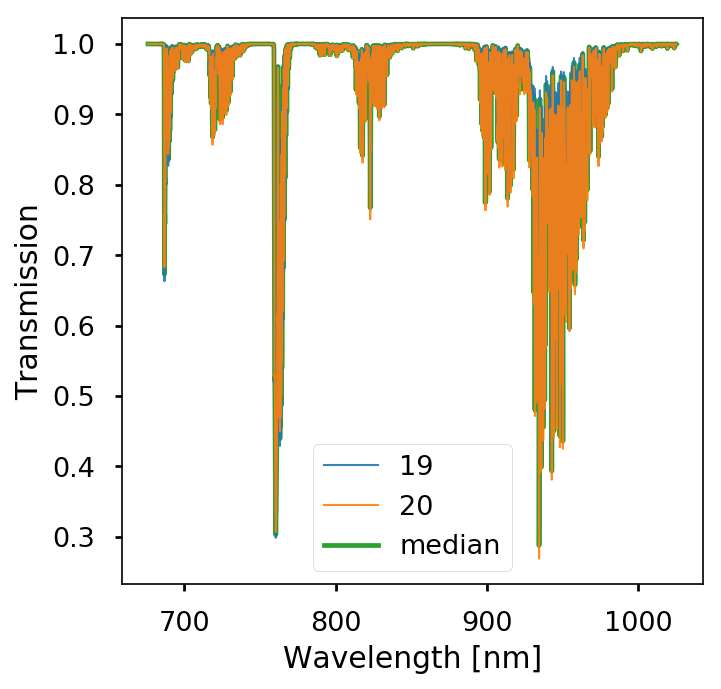

In [8]:
# Load transmission spectrum
trans_std = []
for i in [0,1]:
    star_id = stars.index[i]
    
    # Molecfit output
    spec1D_tell_file = telluric_dir+'/output/star%i_spec1D_uncalib_TAC.txt' % star_id

    tell = np.genfromtxt(spec1D_tell_file, names=True)

    trans_std.append(tell['mtrans'])
    
    plt.plot(tell['WLEN'], tell['mtrans'], lw=1, alpha=0.9, label=star_id)
    
# Take median
trans_std = np.array(trans_std)
trans_std = np.nanmedian(trans_std, axis=0)

trans_std_file = telluric_dir +'BLAS_2019A_transmission.txt'
np.savetxt(spec1D_file, np.vstack((wave_nm, trans_std)).T, header='wave_nm transmission')
np.savetxt(calib_dir+'BLAS_2019A_transmission.txt', np.vstack((wave_nm, trans_std)).T,  header='wave_nm transmission')

plt.plot(tell['WLEN'], trans_std, zorder=0, label='median')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')

## Mask bad telluric region of O2 lines

In [9]:
telluric_regions = {'O2 A band':[757., 775.],
                    'O2 B-band':[685., 694.]}

mask_telluric = np.array([], dtype=int)
for region in telluric_regions:
    mask_telluric = np.hstack((mask_telluric, (np.where((wave_nm > telluric_regions[region][0]) & (wave_nm < telluric_regions[region][1]))[0])))

## Telluric correction and optimization

In [10]:
def std_telluric_region(args, opt_args):
    """RMS of corrected flux in region of O2 A-band"""
    
    alpha, beta = args    
    wave, flux_in, trans_std = opt_args
    
    flux_corr = telluric_correction(wave, flux_in, trans_std, alpha, beta)
    
    return np.nanstd(flux_corr[mask_telluric])

def telluric_correction(wave, flux_in, trans_std, alpha=0., beta=1.):
    """
    Telluric correction (assuming std at same airmass as target)
    
    F_corr = F_in / T(lambda - alpha)**beta
    """
    
    # Translate and scale transmission
    transmission_function = np.interp(wave-alpha, wave, trans_std)**beta
    
    flux_out = flux_in/transmission_function
    flux_out[flux_out == 0.] = np.nan
    
    return flux_out

def optimized_tellcorr(wave, flux_in, trans_std, verbose=False):
    initial_guess = [0, 1.]  # initial guess can be anything
    result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                     args=[wave, flux_in, trans_std])
    if verbose:
        print(result.x)
    return telluric_correction(wave, flux_in, trans_std, alpha=result.x[0], beta=result.x[1])
    

initial_guess = [0, 1.]  # initial guess can be anything
result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                 args=[tell['WLEN'], tell['FLUX'], trans_std])
print(result)

      fun: 1.9735413786281522
 hess_inv: array([[0.00140964, 0.00064837],
       [0.00064837, 0.01771588]])
      jac: array([-9.10460949e-06, -1.93715096e-07])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.00294368, 0.97930055])


# Plot 1D and 2D bino spectra of stars

## Examine spatial psf

PSF = 3.4 pixels = 0.82"

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 39
    # variables        = 3
    chi-square         = 0.01165760
    reduced chi-square = 3.2382e-04
    Akaike info crit   = -310.498983
    Bayesian info crit = -305.508298
[[Variables]]
    sigma:      1.45442602 +/- 0.02371532 (1.63%) (init = 1)
    center:     12.8240374 +/- 0.02371531 (0.18%) (init = 13)
    amplitude:  3.54385526 +/- 0.05004325 (1.41%) (init = 3.021006)
    fwhm:       3.42491147 +/- 0.05584532 (1.63%) == '2.3548200*sigma'
    height:     0.97206303 +/- 0.01372660 (1.41%) == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.577



/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Normalized PSF')

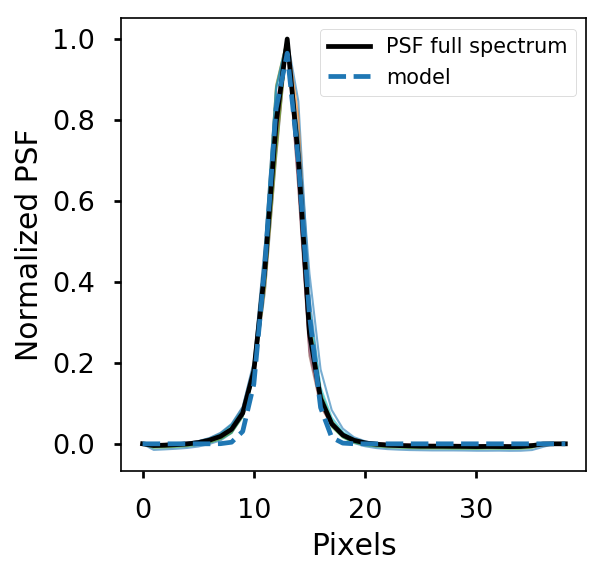

In [11]:
spec2D = extract2D[stars.index[0]+1].data

# PSF varying as function of wavelength?
Npix = 400
plt.figure(figsize=(4,4))
for i in range(spec2D.shape[1])[::Npix]:
    max_i = i+Npix
    if max_i > spec2D.shape[1]: 
        max_i = spec2D.shape[1]
    
    psf = np.nansum(spec2D[:, i:max_i], axis=1)

    med_wave = wave_nm[int(i + (max_i - i)/2)]
    plt.plot(psf/psf.max(), lw=1, alpha=0.6)#, label='%.0f' % med_wave)
    
# Total
psf  = np.nansum(spec2D, axis=1)
psf /= psf.max()
plt.plot(psf, c='k', label='PSF full spectrum')

# Fit with Gaussian
x = np.arange(len(psf))
y = psf

mod  = GaussianModel()
pars = mod.guess(y, x=x)
out  = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

plt.plot(x, out.best_fit, c='tab:blue', ls='dashed', label='model')

plt.legend(fontsize=10)

plt.xlabel('Pixels')
plt.ylabel('Normalized PSF')

## Extract 1D spectrum from 2D and compare with pipeline output

Extracting with boxcar width = 2 FWHM ~ 7 pixels comparable to pipeline

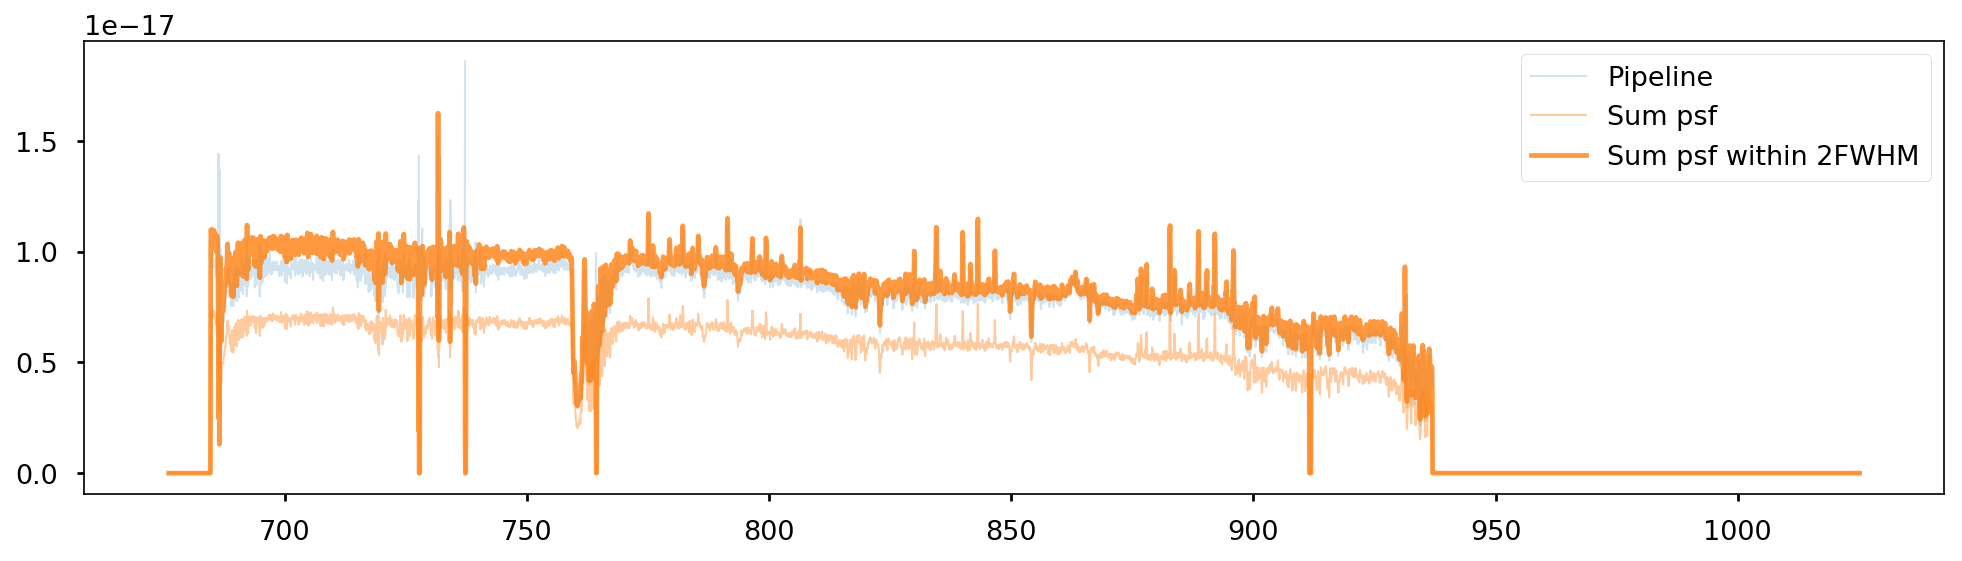

In [12]:
PSF_FWHM = 3.4

col = ['tab:orange','tab:blue']

spec1D_star = spec1D[stars.index[0]]*flux_scale
spec2D_star = extract2D[stars.index[0]+1].data*flux_scale

fig, ax1 = plt.subplots(1, 1, figsize=(16,4), dpi=150)

# From pipeline
ax1.plot(wave_nm, spec1D_star, c=col[1], alpha=0.2, lw=1, label='Pipeline')

# Multiply by PSF and sum
spec1D_sum_psf = np.nansum(spec2D_star*psf[:,None], axis=0)
ax1.plot(wave_nm, spec1D_sum_psf, c=col[0], alpha=0.4, lw=1, label='Sum psf')

# Boxcar with width = psf
FWHM = 2*PSF_FWHM
spec1D_sum_psfFWHM = np.nansum(spec2D_star[int(np.argmax(psf)-FWHM/2):int(np.argmax(psf)+FWHM/2 + 1)], axis=0)
ax1.plot(wave_nm, spec1D_sum_psfFWHM, c=col[0], alpha=0.8, label='Sum psf within 2FWHM')

ax1.legend()

# Plot 1D and 2D spec of both stars

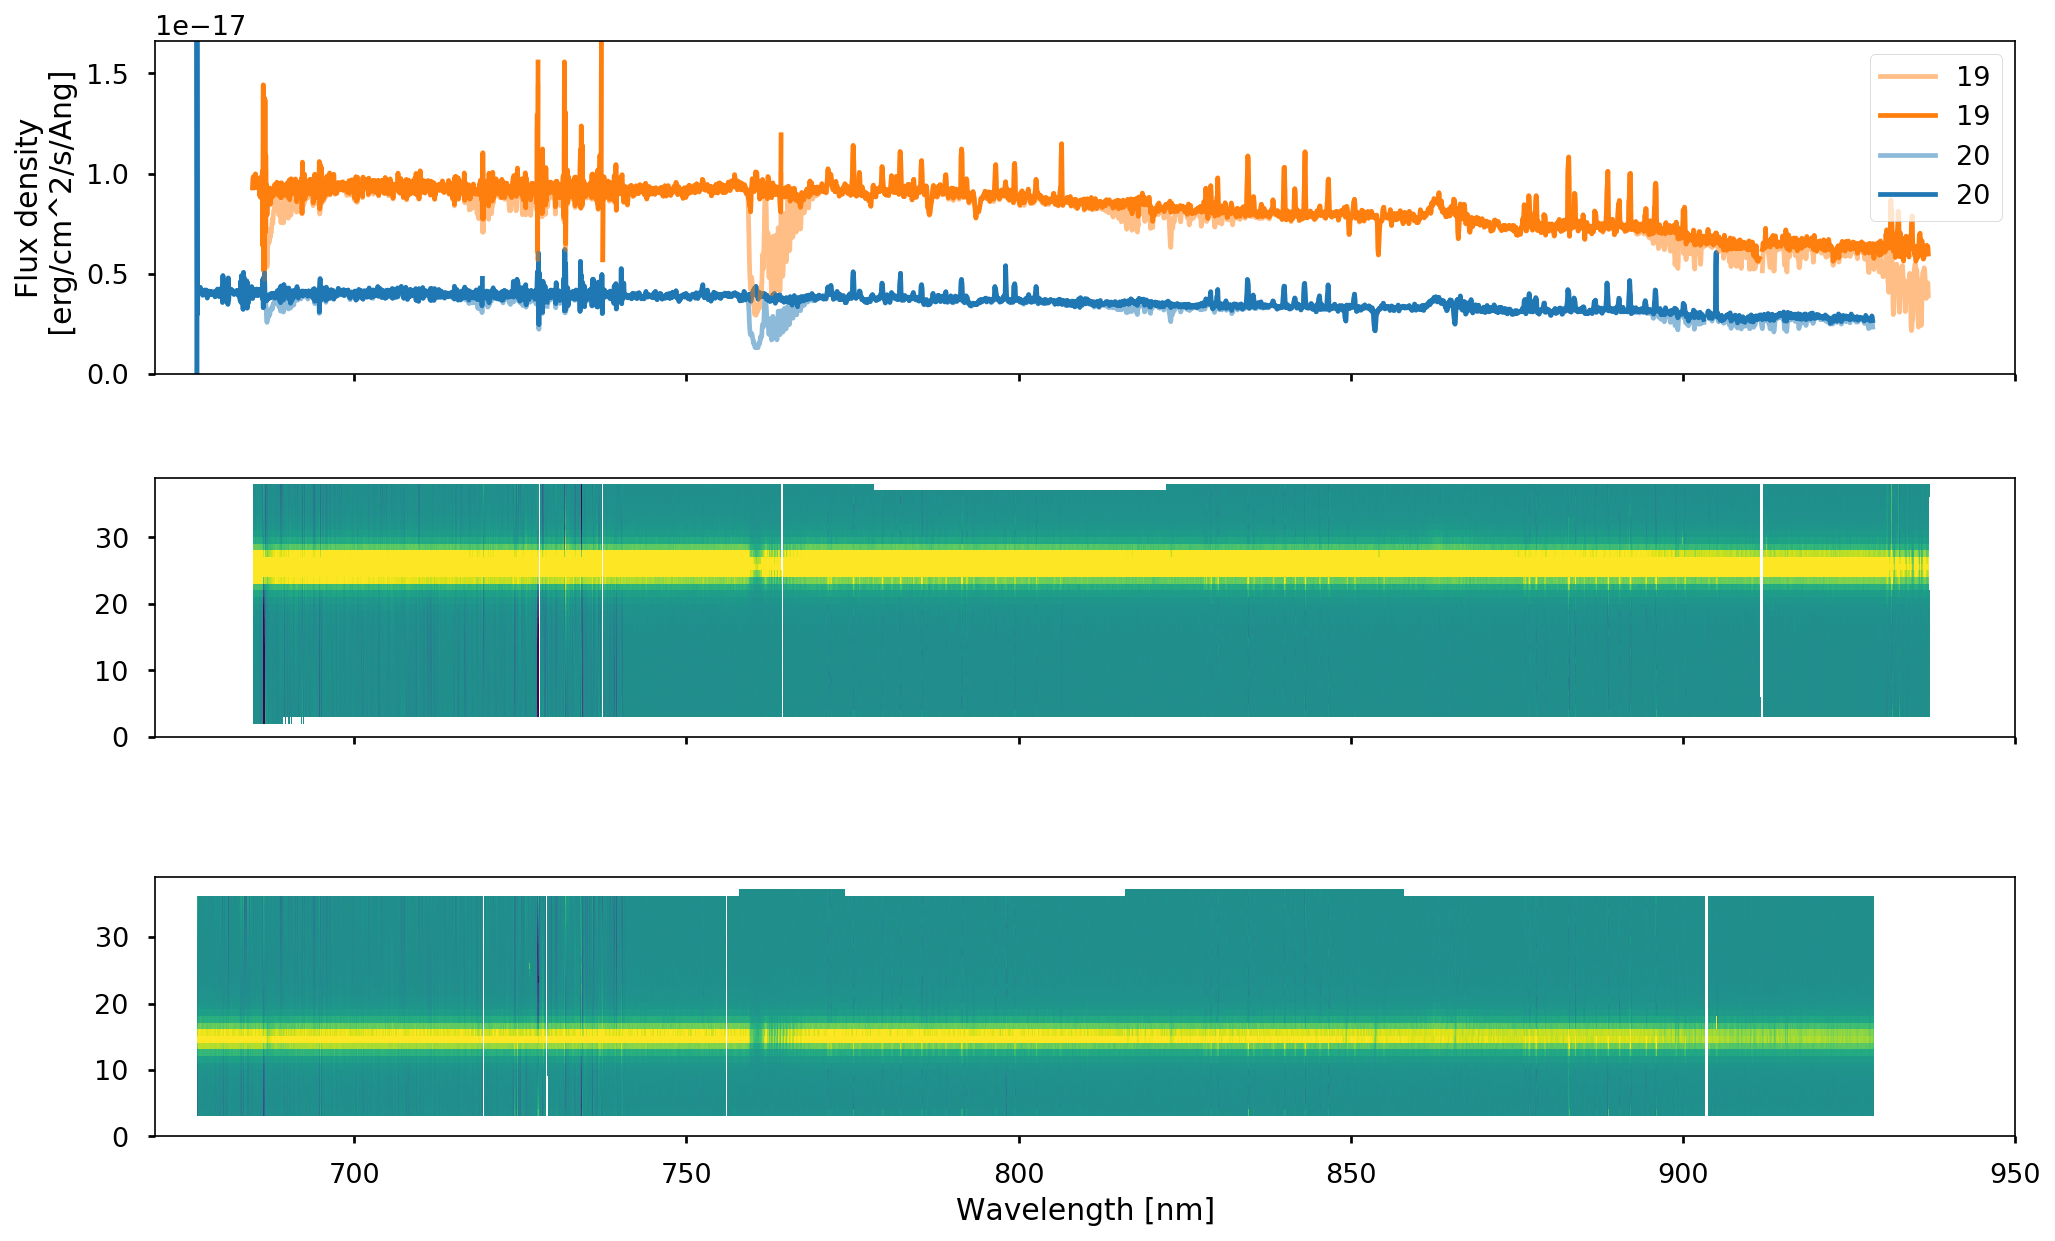

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(16,10), sharex=True, dpi=150)
ax = ax.ravel()

vmin, vmax = -10, 10

# Plot each star
for i in range(2):
    
    spec1D_star = spec1D[stars.index[i]]*flux_scale
    spec2D_star = extract2D[stars.index[i]+1].data
    
    # 1D spectra
    ax[0].plot(wave_nm, spec1D_star, c=col[i], alpha=0.5, label=stars.index[i])

    # telluric corrected
    ax[0].plot(wave_nm, optimized_tellcorr(wave_nm, spec1D[stars.index[i]], trans_std)*flux_scale, 
               c=col[i], label=stars.index[i], zorder=0)
    
    # 2D spectra
    ax[1+i].imshow(spec2D_star, vmin=vmin, vmax=vmax, 
                   extent=[wave_nm.min(), wave_nm.max(), 0., spec2D_star.shape[0]])


ax[2].set_xlabel('Wavelength [%s]' % header['CUNIT1'])
try:
    ax[0].set_ylabel('Flux density\n [%s]' % header['BUNIT'].split('1E-19 ')[-1])
except:
    ax[0].set_ylabel('Flux density\n [counts]')
    
ax[0].set_xlim(670,950)
ax[0].set_ylim(0, np.nanmax(spec1D[stars.index[i]])*flux_scale)
ax[0].legend()

# Load a calibrator star and get magnitude from SDSS

In [14]:
def load_star_spec(star_id, mask_pix=20, tell_corr=True):
    """
    Load star, get flux and wavelength, and coords from bino spectrum
    """

    spec1D_mask = spec1D[star_id].copy()
    if tell_corr:
        # Do telluric correction
        spec1D_mask = optimized_tellcorr(wave_nm, spec1D_mask, trans_std)
    else:
        # Mask bad telluric
        spec1D_mask[mask_telluric] = np.nan

    # Mask edges of detector
    if mask_pix == 0: 
        mask_pix = 1
    finite_mask = np.where(~np.isnan(spec1D_mask))[0]
    spec1D_mask[finite_mask[:mask_pix]]  = np.nan
    spec1D_mask[finite_mask[-mask_pix:]] = np.nan

    # And here you'd get the bino spectrum for the calibrator star.
    # data_pix, data_wave, data_flux = np.genfromtxt("star.csv", delimiter=",", unpack=True, skip_header=1)
    data_pix, data_wave, data_flux  = np.arange(nstep), wave_nm*10., spec1D_mask.copy()
    
    if sky_sub is False:
        # header units are 1e-19 erg/s/cm^2/AA [if'abs']
        data_flux = flux_scale * data_flux.copy()

    # Get from header slit_ra?
    ra, dec = stars.loc[star_id].ra, stars.loc[star_id].dec
#     mag_g, mag_r, mag_i = 23., 23.02, 23.1

    return data_wave, data_flux, ra, dec

# Estimate star i band flux density from SDSS mags

How does it compare with pipeline flux?

In [15]:
# Init flux cal
fluxcal = calbino.FluxCalBino()

19 5.400437904832038e-16
20 2.2085181710012401e-16


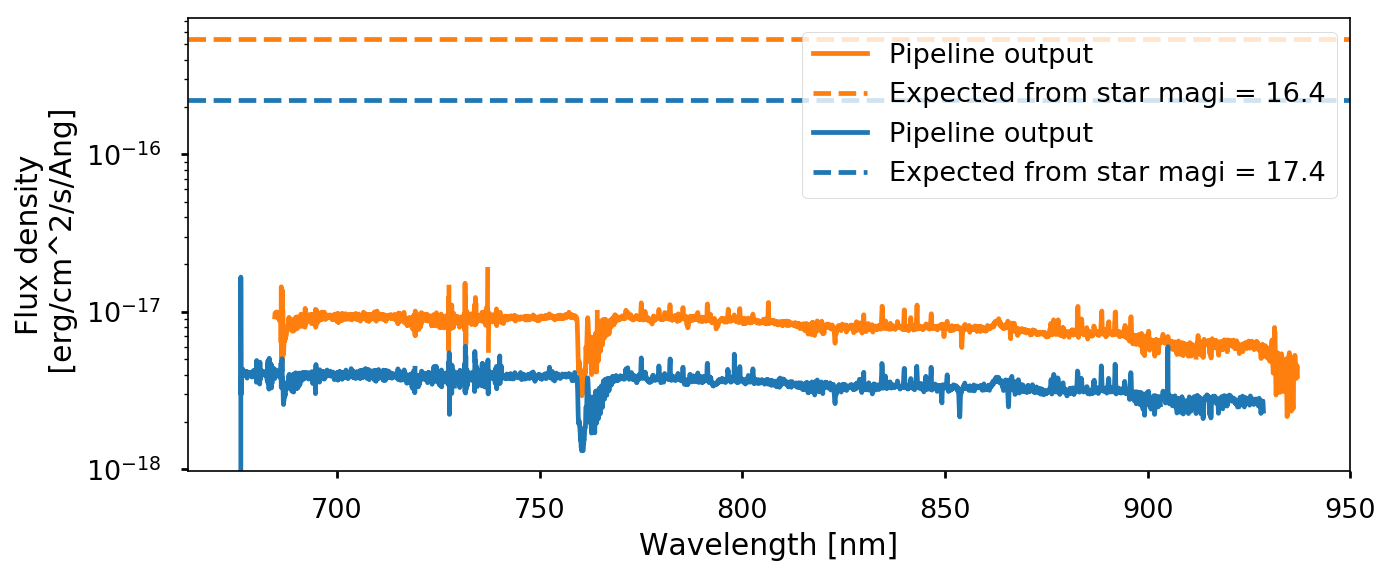

In [16]:
plt.figure(figsize=(10,4))
for i in range(2):
    star_id = stars.index[i]
    data_wave, data_flux, ra, dec = load_star_spec(star_id)
    fluxcal.get_star_mags(ra, dec, verbose=False)
    
    star_mags = fluxcal.star_mags
    
    fluxi = bt.f_cont(star_mags[-1], 7500)
    print(star_id, fluxi)
    
    spec1D_star = spec1D[stars.index[i]]*flux_scale
    
    # 1D spectra
    plt.semilogy(wave_nm, spec1D_star, c=col[i], alpha=1, label='Pipeline output')
    
    plt.axhline(fluxi, c=col[i], ls='dashed', label='Expected from star magi = %.1f' % star_mags[-1])
    
plt.legend()
plt.xlabel('Wavelength [%s]' % header['CUNIT1'])
try:
    plt.ylabel('Flux density\n [%s]' % header['BUNIT'].split('1E-19 ')[-1])
except:
    plt.ylabel('Flux density\n [counts]')

# Do flux calibration and smoothing

## Run for both stars

Not much difference between masking telluric or correcting for it in the flux calibration

19
20
53.804624116894416


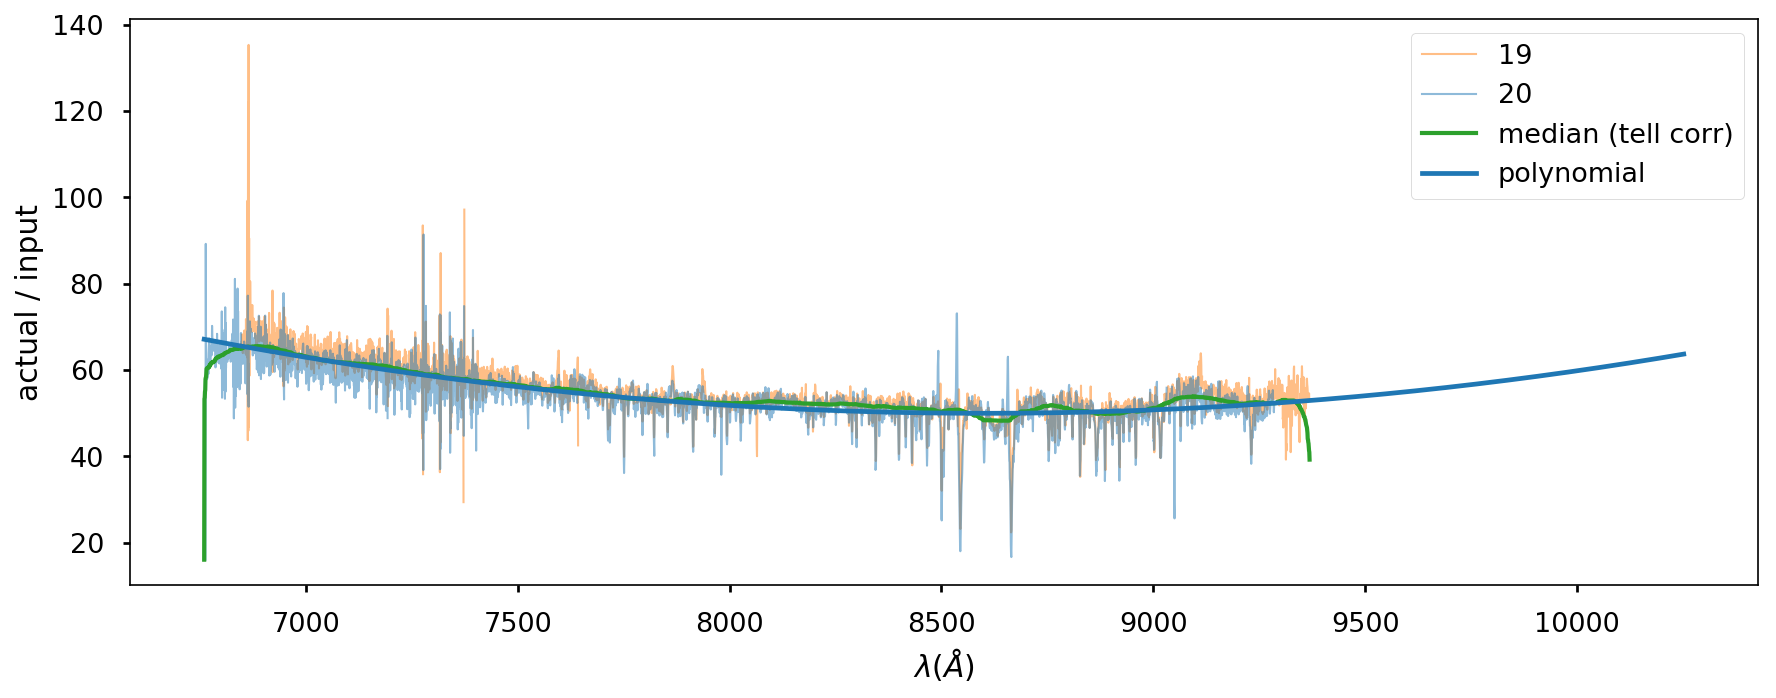

In [18]:
plt.figure(figsize=(14,5))

calibration_both = []
for i in range(2):
    star_id = stars.index[i]
    print(star_id)

    # Load spectrum
    data_wave, data_flux, ra, dec = load_star_spec(star_id, tell_corr=True, mask_pix=0)

    # Match with SDSS mags
    fluxcal.get_star_mags(ra, dec, verbose=False)

    # Do flux calibration
    calibration = fluxcal.flux_calibration(data_flux, data_wave)
    calibration_both.append(calibration)
    
    smoothed_calibration = fluxcal.smooth_calibration(data_wave, calibration, polyfit=False)

    plt.plot(data_wave, calibration, lw=1, c=col[i], label=star_id, alpha=0.5)

# Take median of 2 stars calibrations
calibration_both     = np.array(calibration_both)
calibration_both_med = np.nanmedian(calibration_both, axis=0)

# smooth
smoothed_calibration = fluxcal.smooth_calibration(data_wave, calibration_both_med, 
                                                  polyfit=False, medfilt_kernel_size=201)
plt.plot(data_wave, smoothed_calibration, lw=2, c='tab:green', label='median (tell corr)')

# polyfit to median calibration
polyfitted_calibration = fluxcal.smooth_calibration(data_wave, calibration_both_med, degree=2)
plt.plot(data_wave, polyfitted_calibration, label='polynomial')

# polyfitted_calibration_file = 'BLAS_2019A_fluxcalibration_polyfit%s.txt' % skysub_lab
# np.savetxt(calib_dir+polyfitted_calibration_file, np.vstack((wave_nm, polyfitted_calibration)).T, 
#            header='wave_nm flux_calibration', fmt='%.5e')

plt.legend()
plt.ylabel("actual / input")
plt.xlabel("$\lambda (\AA)$")

print(np.median(polyfitted_calibration))

#  Flux calibration plots

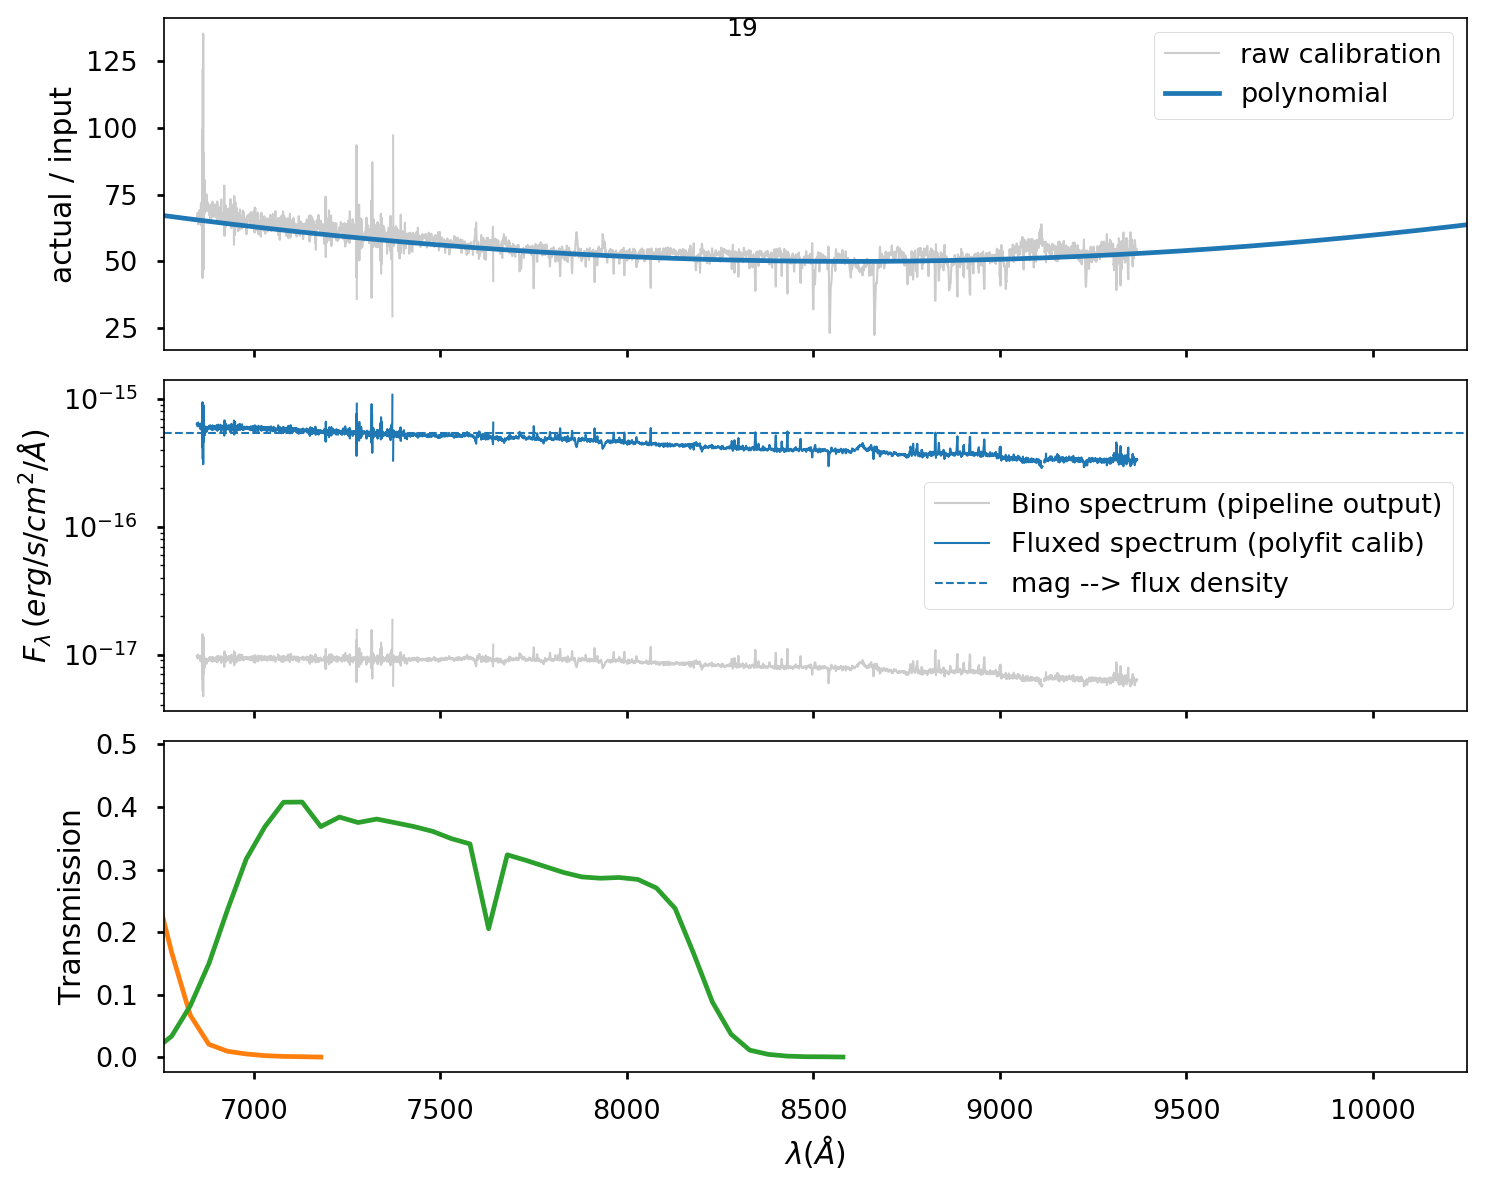

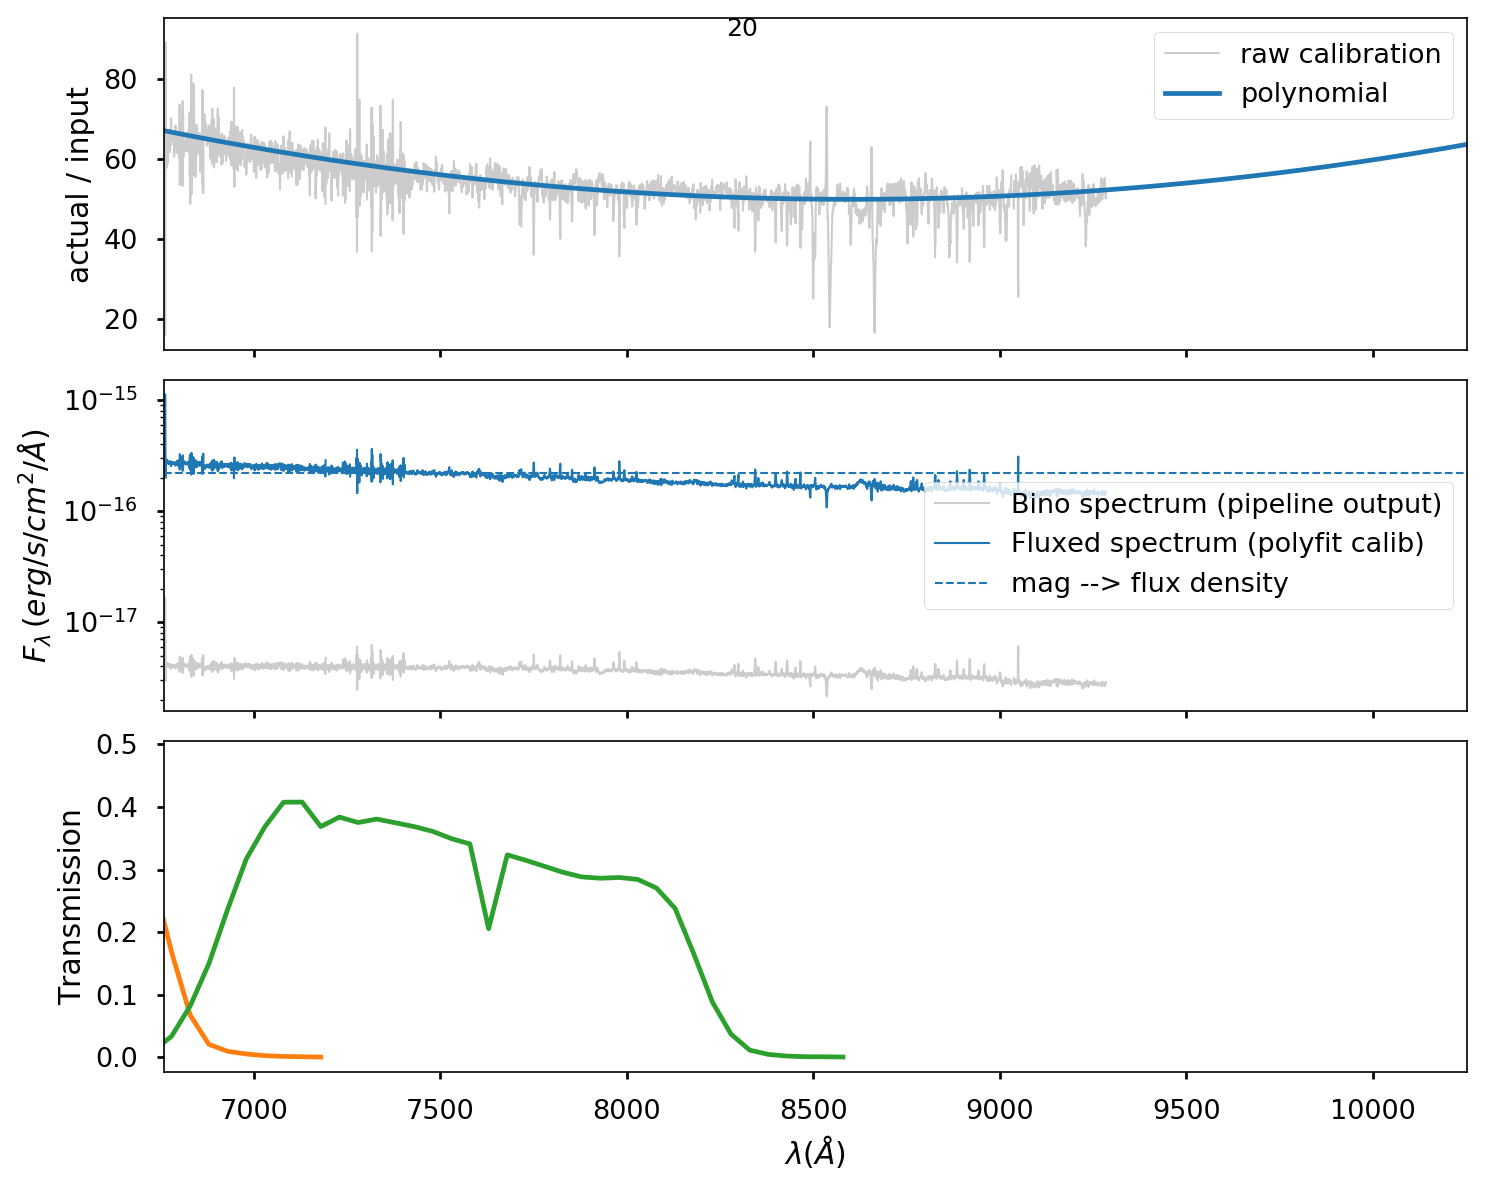

In [105]:
ax = ax.ravel()

for i in range(2):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8), dpi=150)
    
    star_id = stars.index[i]

    fig.suptitle(star_id)
    
    # Load spectrum
    data_wave, data_flux, ra, dec = load_star_spec(star_id, tell_corr=True, mask_pix=0)

    # Match with SDSS mags
    star_mags = get_star_mags(ra, dec, verbose=False)
    
    # Estimate star flux from mag
    fluxi = bt.f_cont(star_mags[-1], 7500)
    
    # Do flux calibration
    calibration = flux_calibration(star_mags, data_flux, data_wave)    
    smoothed_calibration = smooth_calibration(calibration)

    # Calibration
    ax[0].plot(data_wave, calibration, lw=1, c='0.8', label="raw calibration")
#     ax[0].plot(data_wave, smoothed_calibration, label="smoothed calibration")
    ax[0].plot(data_wave, polyfitted_calibration, label='polynomial')    
    
    # Compare flux
    ax[1].semilogy(data_wave, data_flux, lw=1, c='0.8', label="Bino spectrum (pipeline output)")
#     ax[1].plot(data_wave, data_flux*calibration, lw=1, label="Fluxed model")
    ax[1].plot(data_wave, data_flux*polyfitted_calibration, lw=1, label="Fluxed spectrum (polyfit calib)")
    ax[1].axhline(fluxi, lw=1, ls='dashed', label='mag --> flux density')

    ax[0].legend(loc='upper right')
    ax[0].set_ylabel("actual / input")
    ax[0].set_xlim(data_wave.min(), data_wave.max())

    ax[1].legend(loc='center right')
    ax[1].set_ylabel("$F_{\lambda} \, (erg/s/cm^2/\AA)$")

    [f.display(ax=ax[2]) for f in filters]
    ax[2].set_ylabel("Transmission")
    ax[2].set_xlabel("$\lambda (\AA)$")
    
    fig.tight_layout()